# Default import & settings *infer
기존 학습된 모델로 추론만 하려면 *infer 항목만 실행하세요~

In [1]:
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets 
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Conv2D, ReLU, Conv2DTranspose, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import math
import cv2 as cv
from ctypes import windll
import matplotlib.pyplot as plt

%matplotlib inline

D:\Anaconda\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# create new model, load model 모델 번호 부여
modelnumber = 1
main_path = os.path.join('model{}/'.format(modelnumber))
os.makedirs(main_path, exist_ok=True)


In [3]:
def char2key(c):
    # https://msdn.microsoft.com/en-us/library/windows/desktop/ms646329(v=vs.85).aspx
    result = windll.User32.VkKeyScanW(ord(c))
    shift_state = (result & 0xFF00) >> 8
    vk_key = result & 0xFF

    return vk_key

def checkindex(k):
    try:        
        trainpath = glob(main_path + 'train/' + k + '/' + "*.jpg")
        testpath = glob(main_path + 'test/' + k + '/' + "*.jpg")
        trainlist = [os.path.basename(trainpath[i]) for i in range(len(trainpath))]
        trainnum = [int(trainlist[i].replace('.jpg','')) for i in range(len(trainlist))]
        testlist = [os.path.basename(testpath[i]) for i in range(len(testpath))]
        testnum = [int(testlist[i].replace('.jpg','')) for i in range(len(testlist))]
        trainsort = sorted(trainnum)
        testsort = sorted(testnum)
        if trainsort[-1] >= testsort[-1]:
            lastindex = trainsort[-1]
        else:
            lastindex = testsort[-1]
    except:
        lastindex = 0
    return lastindex


def take_snap(event, x, y, flags, param):  
    global img_counter
    if event == cv.EVENT_LBUTTONDOWN:        
        if (img_counter % 5 == 0):
            img_name = os.path.join(main_path + 'test/' + class_name + '/') + "{}.jpg".format(img_counter)
        else:
            img_name = os.path.join(main_path + 'train/' + class_name + '/') + "{}.jpg".format(img_counter)
        os.makedirs(os.path.dirname(img_name), exist_ok=True)
        cv.imwrite(img_name, new_frame)  
        img_counter = img_counter + 1        
    

# Make train data - Record your motions/poses
#### 할당 원하는 키를 누르고 클릭 시 연사
#### 아무것도 안하고 있는 포즈 클래스를 만들어두는 것이 좋음.
#### 포즈는 준비동작 혹은 움직임이 겹치지 않는 것으로 하는 것이 좋음.
#### '/' 를 idle (아무것도 안할때)로 설정

In [8]:
cam = cv.VideoCapture(0)

cv.namedWindow("train")

img_counter = 0

selectedkey = 'none'

while True:
    ret, frame = cam.read()    
    
    # 이미지 뒤집기
    frame_flipped = cv.flip(frame, 1)
    new_frame = frame_flipped.copy()
    if not ret:
        print("failed to grab frame")
        break
    cv.putText(frame_flipped,"* Selected Key: " + selectedkey + "         * saved images: " + str(img_counter) + "     model number: " + str(modelnumber), (10, 450), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))
    cv.imshow("train", frame_flipped)
    
    k = cv.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k == -1:
        continue

    else:        
        selectedkey = chr(k)
        class_name = str(char2key(selectedkey))
        img_counter = checkindex(str(class_name))
        if selectedkey != 'none':
            cv.setMouseCallback("train", take_snap)                            
                
            
            
cam.release()

cv.destroyAllWindows()

Escape hit, closing...


# Prep for Data process *infer

In [9]:
datapath = glob(main_path + 'train/*/*.jpg')
testpath = glob(main_path + 'test/*/*.jpg')

def get_label(path):
    classname = path.split('\\')[-2]
    return classname

def onehot_encoding(label):
    return np.array(label == classlist, np.uint8)

def load_data(path, label):
    cast = tf.cast(path, tf.float32)
    return cast, label

In [10]:
classes = [get_label(path) for path in datapath]
test_classes = [get_label(path) for path in testpath]
classlist = np.unique(classes)
test_classlist = np.unique(test_classes)
num_class = len(classlist)
#onehot encode labels
labels = [onehot_encoding(classname) for classname in classes]
test_labels = [onehot_encoding(classname) for classname in test_classes]
# create list for input side
pclasslist = os.listdir(main_path + 'train')
#figure out which class is idle
# change '191' to whatever key you'd want for idle later or it will be updated when I get a UI up.
idle = [idx for idx, s in enumerate(classlist) if '191' in s][0]
# define second key - when I get a UI will add in second and more key presses
secondkey = [None] * len(pclasslist)
pred_classes = []
for i in range(num_class):
    templist = int(pclasslist[i]), secondkey[i]
    pred_classes.append(templist)

In [11]:
with open('mylist', 'wb') as f:
     pickle.dump(pred_classes, f) 
with open('classlist', 'wb') as f1:
    pickle.dump(classlist, f1)

In [12]:
classlist


array(['191', '65', '66'], dtype='<U3')

In [13]:
with open('keyposelist', 'rb') as f:
     pred_classes = pickle.load(f)
with open('classlist', 'rb') as f1:
     classlist = pickle.load(f1)

# set up posenet *infer

In [14]:
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

def interpret(data):
    template_image_src = cv.imread(data)
    # src_tepml_width, src_templ_height, _ = template_image_src.shape 
    template_image = cv.resize(template_image_src, (width, height))
    template_input = np.expand_dims(template_image.copy(), axis=0)
    floating_model = input_details[0]['dtype'] == np.float32
    if floating_model:
      template_input = (np.float32(template_input) - 127.5) / 127.5
      
    interpreter.set_tensor(input_details[0]['index'], template_input)
    # Runs the computation
    interpreter.invoke()
    # Extract output data from the interpreter
    template_output_data = interpreter.get_tensor(output_details[0]['index'])
    template_offset_data = interpreter.get_tensor(output_details[1]['index'])
    template_offsets = np.squeeze(template_offset_data)
    return template_offsets

def prediction(data):
    # src_tepml_width, src_templ_height, _ = template_image_src.shape 
    test_image = cv.resize(data, (width, height))
    test_input = np.expand_dims(test_image.copy(), axis=0)
    floating_model = input_details[0]['dtype'] == np.float32
    if floating_model:
        test_input = (np.float32(test_input) - 127.5) / 127.5
    interpreter.set_tensor(input_details[0]['index'], test_input)
    # Runs the computation   
    interpreter.invoke()
    
    test_offset_data = interpreter.get_tensor(output_details[1]['index'])
    #test_offsets = np.squeeze(test_offset_data)
    # Extract output data from the interpreter
    return test_offset_data

# Create dataset

In [15]:
# hyper parameter
num_epochs = 50
batch_size = 4

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (9, 9, 34)
num_classes = num_class

#### 데이터를 posenet에 돌린후 데이터셋으로 만들기

In [16]:
interpreted = [interpret(data) for data in datapath]
test_interpreted = [interpret(data) for data in testpath]

AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = tf.data.Dataset.from_tensor_slices((interpreted, labels))
dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size=len(datapath))
dataset = dataset.repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((test_interpreted, test_labels))
test_dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
test_dataset = dataset.batch(batch_size)
test_dataset = dataset.repeat()

In [17]:
# set up classification model

inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(128)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='CNN')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

## Train

In [18]:
steps_per_epoch = len(datapath) // batch_size
validation_steps = len(testpath) // batch_size

steps_per_epoch, validation_steps
model.fit_generator(
    dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
30/30 [==============================] - 0s 7ms/step - loss: 6.4248 - accuracy: 0.6186 - val_loss: 0.3605 - val_accuracy: 0.8929
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 1.7446 - accuracy: 0.7797 - val_loss: 6.7011e-06 - val_accuracy: 1.0000
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.2914 - accuracy: 0.9237 - val_loss: 4.0792e-04 - val_accuracy: 1.0000
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9576 - val_loss: 9.3264e-05 - val_accuracy: 1.0000
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2034 - accuracy: 0.9492 - val_loss: 1.5132e-04 - val_accuracy: 1.0000
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.0519 - accuracy: 0.9915 - val_loss: 3.4485e-06 - val_accuracy: 1.0000
Epoch 7/50
30/30 [==============================] - 0s 3ms/step 

## load your pretrained model (skip if first time.)*infer

In [7]:
model = tf.keras.models.load_model(os.path.join(main_path + 'posenettocnn2'))

OSError: SavedModel file does not exist at: model2/posenettocnn2/{saved_model.pbtxt|saved_model.pb}

In [141]:
print(model.summary())

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 9, 34)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          9824      
_________________________________________________________________
activation (Activation)      (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0 

# Save Model

In [16]:
model.save(os.path.join(main_path + 'posenettocnn_sm'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model2/posenettocnn_sm\assets


# Test with single Image

[(191, None), (47, None), (81, None), (90, None)]
[[0.00677992 0.96065044 0.0325696 ]]
[1]


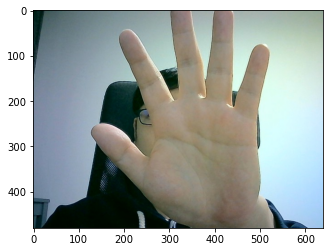

In [19]:
# '43.jpg'를 동일폴더에 있는 다른 파일로 교체하면 됨.
data = cv.imread('43.jpg')
testimg_i = prediction(data)
pred_class = model.predict(testimg_i)
plt.imshow(cv.cvtColor(data, cv.COLOR_BGR2RGB))

print(pred_classes)
print(pred_class)
print(np.argmax(pred_class, axis=-1))

# Prep for motion prediction and converting to input *infer

In [20]:
import ctypes
from ctypes import wintypes
import time
user32 = ctypes.WinDLL('user32', use_last_error=True)
INPUT_KEYBOARD = 1
KEYEVENTF_EXTENDEDKEY = 0x0001
KEYEVENTF_KEYUP       = 0x0002
KEYEVENTF_UNICODE     = 0x0004
MAPVK_VK_TO_VSC = 0
# msdn.microsoft.com/en-us/library/dd375731
wintypes.ULONG_PTR = wintypes.WPARAM
class MOUSEINPUT(ctypes.Structure):
    _fields_ = (("dx",          wintypes.LONG),
                ("dy",          wintypes.LONG),
                ("mouseData",   wintypes.DWORD),
                ("dwFlags",     wintypes.DWORD),
                ("time",        wintypes.DWORD),
                ("dwExtraInfo", wintypes.ULONG_PTR))
class KEYBDINPUT(ctypes.Structure):
    _fields_ = (("wVk",         wintypes.WORD),
                ("wScan",       wintypes.WORD),
                ("dwFlags",     wintypes.DWORD),
                ("time",        wintypes.DWORD),
                ("dwExtraInfo", wintypes.ULONG_PTR))
    def __init__(self, *args, **kwds):
        super(KEYBDINPUT, self).__init__(*args, **kwds)
        if not self.dwFlags & KEYEVENTF_UNICODE:
            self.wScan = user32.MapVirtualKeyExW(self.wVk,
                                                 MAPVK_VK_TO_VSC, 0)
class HARDWAREINPUT(ctypes.Structure):
    _fields_ = (("uMsg",    wintypes.DWORD),
                ("wParamL", wintypes.WORD),
                ("wParamH", wintypes.WORD))
class INPUT(ctypes.Structure):
    class _INPUT(ctypes.Union):
        _fields_ = (("ki", KEYBDINPUT),
                    ("mi", MOUSEINPUT),
                    ("hi", HARDWAREINPUT))
    _anonymous_ = ("_input",)
    _fields_ = (("type",   wintypes.DWORD),
                ("_input", _INPUT))
LPINPUT = ctypes.POINTER(INPUT)
def PressKey(hexKeyCode, y=None):
    x = INPUT(type=INPUT_KEYBOARD,
              ki=KEYBDINPUT(wVk=hexKeyCode))
    user32.SendInput(1, ctypes.byref(x), ctypes.sizeof(x))
    if y != None:
        y = INPUT(type=INPUT_KEYBOARD,
              ki=KEYBDINPUT(wVk=y))
        user32.SendInput(1, ctypes.byref(y), ctypes.sizeof(y))
def ReleaseKey(hexKeyCode, y=None):
    x = INPUT(type=INPUT_KEYBOARD,
              ki=KEYBDINPUT(wVk=hexKeyCode,
                            dwFlags=KEYEVENTF_KEYUP))
    user32.SendInput(1, ctypes.byref(x), ctypes.sizeof(x))
    if y != None:
        y = INPUT(type=INPUT_KEYBOARD,
              ki=KEYBDINPUT(wVk=y, dwFlags=KEYEVENTF_KEYUP))
        user32.SendInput(1, ctypes.byref(y), ctypes.sizeof(y))

def EnterKey(keyinput):
    key1 = pred_classes[keyinput][0]
    key2 = pred_classes[keyinput][1]
    if keyinput != idle:
        PressKey(key1, key2) #start
        time.sleep(0.1)
        ReleaseKey(key1, key2)
    
    # you can change 0x30 to any key you want. For more info look at :
    # msdn.microsoft.com/en-us/library/dd375731


In [21]:
def preprocessing(frame):
    # 사이즈 조정
    #size = (257, 257)
    #frame_resized = cv.resize(frame, size, interpolation=cv.INTER_AREA)
    
    # 이미지 정규화
    frame_normalized = (frame.astype(np.float32) / 127.0) - 1
    #frame_reshaped = frame_normalized.reshape((1, 257, 257, 3))
    frame_pred = prediction(frame_normalized)
    # 이미지 차원 재조정 - 예측을 위해 reshape 해줍니다.
    
    
    return frame_pred

# Run Cam and predict *infer

In [22]:
# 카메라 캡쳐 객체, 0=내장 카메라
capture = cv.VideoCapture(0)

# 캡쳐 프레임 사이즈 조절, 버퍼, FPS 설정
capture.set(cv.CAP_PROP_FRAME_WIDTH, 257)
capture.set(cv.CAP_PROP_FRAME_HEIGHT, 257)
capture.set(cv.CAP_PROP_FPS, 30)

# 변수 초기화
pred_class = None
repeat_count = 0
pred_count = 0

# 예측 확정 시간 설정
repeat_num = 2

# 예측 주기 설정
pred_num = 2


while True:
    ret, frame = capture.read()
    #if ret == True: 
    #    print("read success!")

    # 이미지 뒤집기
    frame_fliped = cv.flip(frame, 1)
    
    # 이미지 출력
    cv.imshow("VideoFrame", frame_fliped)
    #plt.imshow(frame_fliped, cmap = 'gray', interpolation = 'bicubic')
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    #plt.show()
    
  
    if cv.waitKey(1) == 27: #esc 눌러서 끄기        
        break
    
    # 데이터 전처리
    preprocessed = prediction(frame_fliped)

    # 예측
    pred_count = pred_count + 1
    if pred_count % pred_num:
        b_pred_class = pred_class
        pred = model.predict(preprocessed)
        pred_class = int(np.argmax(pred, axis=-1))
        print(pred_class, end='')
        
        if b_pred_class == pred_class:
            repeat_count = repeat_count + 1
            if repeat_count % repeat_num:
                EnterKey(pred_class)
                
        else:
            count = 0
           
    
# 카메라 객체 반환
capture.release() 
# 화면에 나타난 윈도우들을 종료
cv.destroyAllWindows()

0000000000000110000000000000000001111100000000000000

## Change allocated keys to pose or add second key simultanous press

In [23]:
#현재 등록된 클래스(포즈)
print(pred_classes)

[(191, None), (47, None), (81, None), (90, None)]


In [24]:
# https://docs.microsoft.com/en-us/windows/win32/inputdev/virtual-key-codes
# 위 링크를 참고하여 키의 hex 코드 파악하여 직접 pred_classes에 바꿔치기
# 0x41 = a, 0x42 b 등등. 밑에는 포즈에 등록된 키가 뭔지 다시 파악하려면 실행
back_to_hex = [hex(pred_classes[i][0]) for i in range(len(pred_classes))]
print(back_to_hex)

['0xbf', '0x2f', '0x51', '0x5a']


In [29]:
chr(0x5a)

'Z'

In [16]:
# 아래 method로 원하는 키의 ascii 코드를 파악해도 됨.
char2key('0x7b')

NameError: name 'char2key' is not defined

In [31]:
'''위에서 뽑은 입력 리스트를 복사해서, 
None을 원하는 키로 바꾸고 실행 시 동시(순차) 입력됨 
예를 들어 (65, 50)으로 바꾸면 a, 2를 입력하는 것과 같은 효과'''
# pred_classes = [(81, 0x01), (66, None)]


'위에서 뽑은 입력 리스트를 복사해서, \nNone을 원하는 키로 바꾸고 실행 시 동시(순차) 입력됨 \n예를 들어 (65, 50)으로 바꾸면 a, 2를 입력하는 것과 같은 효과'